In [1]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d apollo2506/eurosat-dataset


Dataset URL: https://www.kaggle.com/datasets/apollo2506/eurosat-dataset
License(s): CC0-1.0
 99% 2.03G/2.04G [00:31<00:00, 130MB/s]
100% 2.04G/2.04G [00:31<00:00, 69.1MB/s]


In [3]:
!unzip eurosat-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: EuroSATallBands/River/River_1990.tif  
  inflating: EuroSATallBands/River/River_1991.tif  
  inflating: EuroSATallBands/River/River_1992.tif  
  inflating: EuroSATallBands/River/River_1993.tif  
  inflating: EuroSATallBands/River/River_1994.tif  
  inflating: EuroSATallBands/River/River_1995.tif  
  inflating: EuroSATallBands/River/River_1996.tif  
  inflating: EuroSATallBands/River/River_1997.tif  
  inflating: EuroSATallBands/River/River_1998.tif  
  inflating: EuroSATallBands/River/River_1999.tif  
  inflating: EuroSATallBands/River/River_2.tif  
  inflating: EuroSATallBands/River/River_20.tif  
  inflating: EuroSATallBands/River/River_200.tif  
  inflating: EuroSATallBands/River/River_2000.tif  
  inflating: EuroSATallBands/River/River_2001.tif  
  inflating: EuroSATallBands/River/River_2002.tif  
  inflating: EuroSATallBands/River/River_2003.tif  
  inflating: EuroSATallBands/River/River_2004.tif  
  inflating: EuroSA

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from PIL import Image
from timeit import default_timer as timer
from tqdm import tqdm
from tqdm.auto import tqdm
import os
import shutil
from sklearn.model_selection import train_test_split

In [5]:
dataset_dir = Path(r"/content/eurosat-dataset/EuroSAT")
print(dataset_dir)

/content/eurosat-dataset/EuroSAT


In [6]:
class Args:
    def __init__(self, dataset_folder='/content/EuroSAT', split_ratios=(0.7, 0.15, 0.15)):
        self.im_width, self.im_height = 224, 224
        self.lr = 0.0008
        self.batch_size = 32


        self.dataset_folder = dataset_folder
        self.train_dir = os.path.join(dataset_folder, 'train')
        self.valid_dir = os.path.join(dataset_folder, 'valid')
        self.test_dir = os.path.join(dataset_folder, 'test')


        self.split_ratios = split_ratios
        self._create_splits()

    def _create_splits(self):

        for dir_path in [self.train_dir, self.valid_dir, self.test_dir]:
            os.makedirs(dir_path, exist_ok=True)


        class_dirs = [d for d in os.listdir(self.dataset_folder) if os.path.isdir(os.path.join(self.dataset_folder, d))]
        for class_dir in class_dirs:
            class_path = os.path.join(self.dataset_folder, class_dir)
            if class_path in [self.train_dir, self.valid_dir, self.test_dir]:
                continue


            all_files = [os.path.join(class_path, f) for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]


            train_files, temp_files = train_test_split(all_files, test_size=1 - self.split_ratios[0], random_state=42)
            valid_files, test_files = train_test_split(temp_files, test_size=self.split_ratios[2] / sum(self.split_ratios[1:]), random_state=42)


            for subset, subset_files in zip(['train', 'valid', 'test'], [train_files, valid_files, test_files]):
                subset_class_dir = os.path.join(self.dataset_folder, subset, class_dir)
                os.makedirs(subset_class_dir, exist_ok=True)
                for file in subset_files:
                    shutil.move(file, subset_class_dir)


args = Args()


In [7]:
import pathlib

In [8]:
train_dir = pathlib.Path("/content/EuroSAT/train")
val_dir = pathlib.Path('/content/EuroSAT/valid')
test_dir = pathlib.Path('/content/EuroSAT/test')

print(f"Train Directory : {train_dir}")
print(f"Validation Directory : {val_dir}")
print(f"Test Directory : {test_dir}")


Train Directory : /content/EuroSAT/train
Validation Directory : /content/EuroSAT/valid
Test Directory : /content/EuroSAT/test


In [9]:
total_class_train = len(os.listdir(train_dir))

total_class_val = len(os.listdir(val_dir))

total_test = len(os.listdir(test_dir))

print(f"Total of Train Data Classes: {total_class_train} classes")
print(f"Total of Validation Data Classes: {total_class_val} classes")
print(f"Total of Test Data: {total_test} classes")


Total of Train Data Classes: 10 classes
Total of Validation Data Classes: 10 classes
Total of Test Data: 10 classes


In [10]:
def count_data_per_class(path):
    classes = sorted(os.listdir(path))
    class_counts = {}
    for cls in classes:
        class_path = os.path.join(path, cls)
        class_counts[cls] = len(os.listdir(class_path))
    return class_counts

In [11]:
train_class_counts = count_data_per_class(train_dir)
val_class_counts = count_data_per_class(val_dir)

In [12]:
train_counts_df = pd.DataFrame.from_dict(train_class_counts, orient="index", columns=["Count"])
val_counts_df = pd.DataFrame.from_dict(val_class_counts, orient="index", columns=["Count"])


In [13]:
print(f"Total Image for Training: {sum(train_class_counts.values())} images")
print(f"Total Image for Validation: {sum(val_class_counts.values())} images")


Total Image for Training: 18890 images
Total Image for Validation: 4050 images


In [14]:
train_counts_df

,Count
AnnualCrop,2099
Forest,2099
HerbaceousVegetation,2099
Highway,1749
Industrial,1749
Pasture,1399
PermanentCrop,1749
Residential,2099
River,1749
SeaLake,2099


In [15]:
val_counts_df

,Count
AnnualCrop,450
Forest,450
HerbaceousVegetation,450
Highway,375
Industrial,375
Pasture,300
PermanentCrop,375
Residential,450
River,375
SeaLake,450


In [16]:

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = datasets.ImageFolder(root=str(train_dir), transform=train_transforms)
val_dataset = datasets.ImageFolder(root=str(val_dir), transform=val_transforms)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [17]:
import timm
model = timm.create_model('xception', pretrained=True)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for param in model.parameters():
    param.requires_grad = False


model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))


model = model.to(device)


criterion = nn.CrossEntropyLoss()


optimizer = Adam(model.fc.parameters(), lr=0.001)


scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)





<ipython-input-19-a42f15413e96>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/5:   0%|          | 0/591 [00:00<?, ?it/s]<ipython-input-19-a42f15413e96>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/5: 100%|██████████| 591/591 [01:23<00:00,  7.11it/s]


Epoch 1/5: Train Loss = 0.8225, Train Acc = 0.8019, Val Loss = 0.6580, Val Acc = 0.8230


Epoch 2/5: 100%|██████████| 591/591 [01:20<00:00,  7.32it/s]


Epoch 2/5: Train Loss = 0.4801, Train Acc = 0.8623, Val Loss = 0.4476, Val Acc = 0.8568


Epoch 3/5: 100%|██████████| 591/591 [01:18<00:00,  7.56it/s]


Epoch 3/5: Train Loss = 0.4206, Train Acc = 0.8714, Val Loss = 0.3905, Val Acc = 0.8765


Epoch 4/5: 100%|██████████| 591/591 [01:16<00:00,  7.72it/s]


Epoch 4/5: Train Loss = 0.3968, Train Acc = 0.8772, Val Loss = 0.3859, Val Acc = 0.8807


Epoch 5/5: 100%|██████████| 591/591 [01:17<00:00,  7.64it/s]


Epoch 5/5: Train Loss = 0.3668, Train Acc = 0.8843, Val Loss = 0.4586, Val Acc = 0.8551

Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.86      0.91      0.88       450
              Forest       0.90      0.84      0.87       450
HerbaceousVegetation       0.91      0.76      0.83       450
             Highway       0.79      0.88      0.83       375
          Industrial       0.94      0.87      0.90       375
             Pasture       0.84      0.87      0.85       300
       PermanentCrop       0.93      0.73      0.82       375
         Residential       0.81      0.98      0.88       450
               River       0.88      0.71      0.78       375
             SeaLake       0.78      0.97      0.87       450

            accuracy                           0.86      4050
           macro avg       0.86      0.85      0.85      4050
        weighted avg       0.86      0.86      0.85      4050



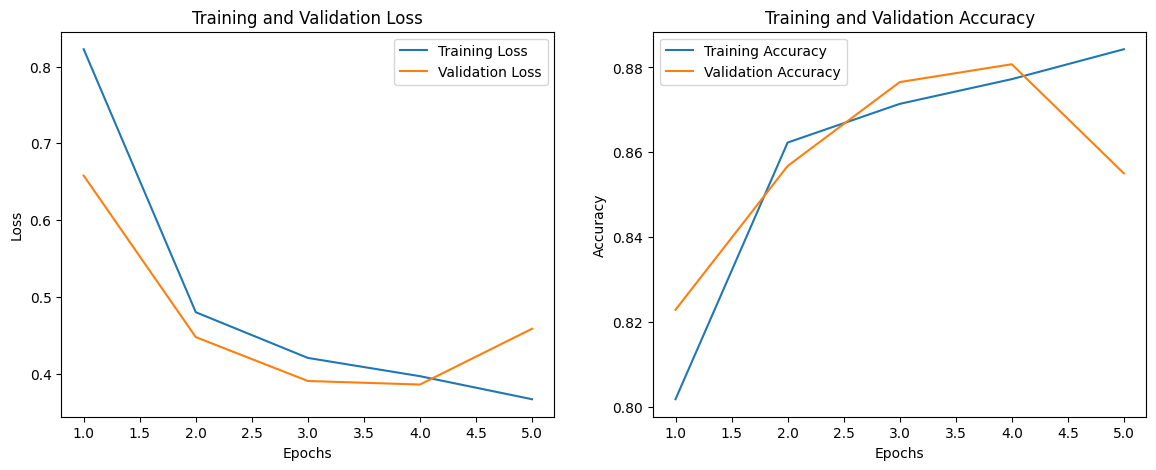

In [19]:
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import classification_report
from tqdm import tqdm


scaler = GradScaler()


def train_model_with_visuals(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=5, patience=3):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_val_acc = 0
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)


            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()


            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_acc = correct_train / total_train


        model.eval()
        val_loss, correct, total = 0, 0, 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_acc = correct / total
        history["train_loss"].append(train_loss / len(train_loader))
        history["val_loss"].append(val_loss / len(val_loader))
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {train_loss/len(train_loader):.4f}, "
              f"Train Acc = {train_acc:.4f}, Val Loss = {val_loss/len(val_loader):.4f}, Val Acc = {val_acc:.4f}")


        if epoch == epochs - 1:
            print("\nClassification Report:")
            print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))


        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping!")
                break


        scheduler.step()

    return history


history = train_model_with_visuals(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=5, patience=3)


def plot_training_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(14, 5))


    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Training Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Training Accuracy")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.show()


plot_training_history(history)


##acuracy+loss plotting

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import label_binarize
import pandas as pd
import re

In [21]:

def evaluate_and_plot_roc_auc(model, val_loader, classes, train_dataset):
    model.eval()
    all_preds, all_labels = [], []
    all_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = nn.Softmax(dim=1)(outputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())


    report = classification_report(all_labels, all_preds, target_names=classes)
    print(report)
    with open("classification_report.txt", "w") as f:
        f.write(report)


    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(14, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes,
                cbar=False, annot_kws={"size": 12}, linewidths=0.5)
    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    plt.show()


    df = pd.DataFrame({"True Labels": all_labels, "Predictions": all_preds})
    df.to_csv("model_predictions.csv", index=False)


    all_labels_bin = label_binarize(all_labels, classes=range(len(classes)))


    plt.figure(figsize=(14, 10))
    for i, class_name in enumerate(classes):
        fpr, tpr, _ = roc_curve(all_labels_bin[:, i], [p[i] for p in all_probs])
        auc_score = roc_auc_score(all_labels_bin[:, i], [p[i] for p in all_probs])
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc_score:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.title("ROC Curve and AUC", fontsize=16)
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
    plt.tight_layout()
    plt.savefig("roc_auc.png", dpi=300, bbox_inches="tight")
    plt.show()


    fpr, tpr, _ = roc_curve(all_labels_bin.ravel(), [p for probs in all_probs for p in probs])
    auc_micro = roc_auc_score(all_labels_bin, all_probs, average='micro', multi_class='ovr')

    plt.figure(figsize=(14, 10))
    plt.plot(fpr, tpr, label=f"Micro-Average (AUC = {auc_micro:.2f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.title("ROC Curve and AUC (Micro-Average)", fontsize=16)
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
    plt.tight_layout()
    plt.savefig("roc_auc_micro.png", dpi=300, bbox_inches="tight")
    plt.show()

                      precision    recall  f1-score   support

          AnnualCrop       0.86      0.91      0.88       450
              Forest       0.90      0.84      0.87       450
HerbaceousVegetation       0.91      0.76      0.83       450
             Highway       0.79      0.88      0.83       375
          Industrial       0.94      0.87      0.90       375
             Pasture       0.84      0.87      0.85       300
       PermanentCrop       0.93      0.73      0.82       375
         Residential       0.81      0.98      0.88       450
               River       0.88      0.71      0.78       375
             SeaLake       0.78      0.97      0.87       450

            accuracy                           0.86      4050
           macro avg       0.86      0.85      0.85      4050
        weighted avg       0.86      0.86      0.85      4050



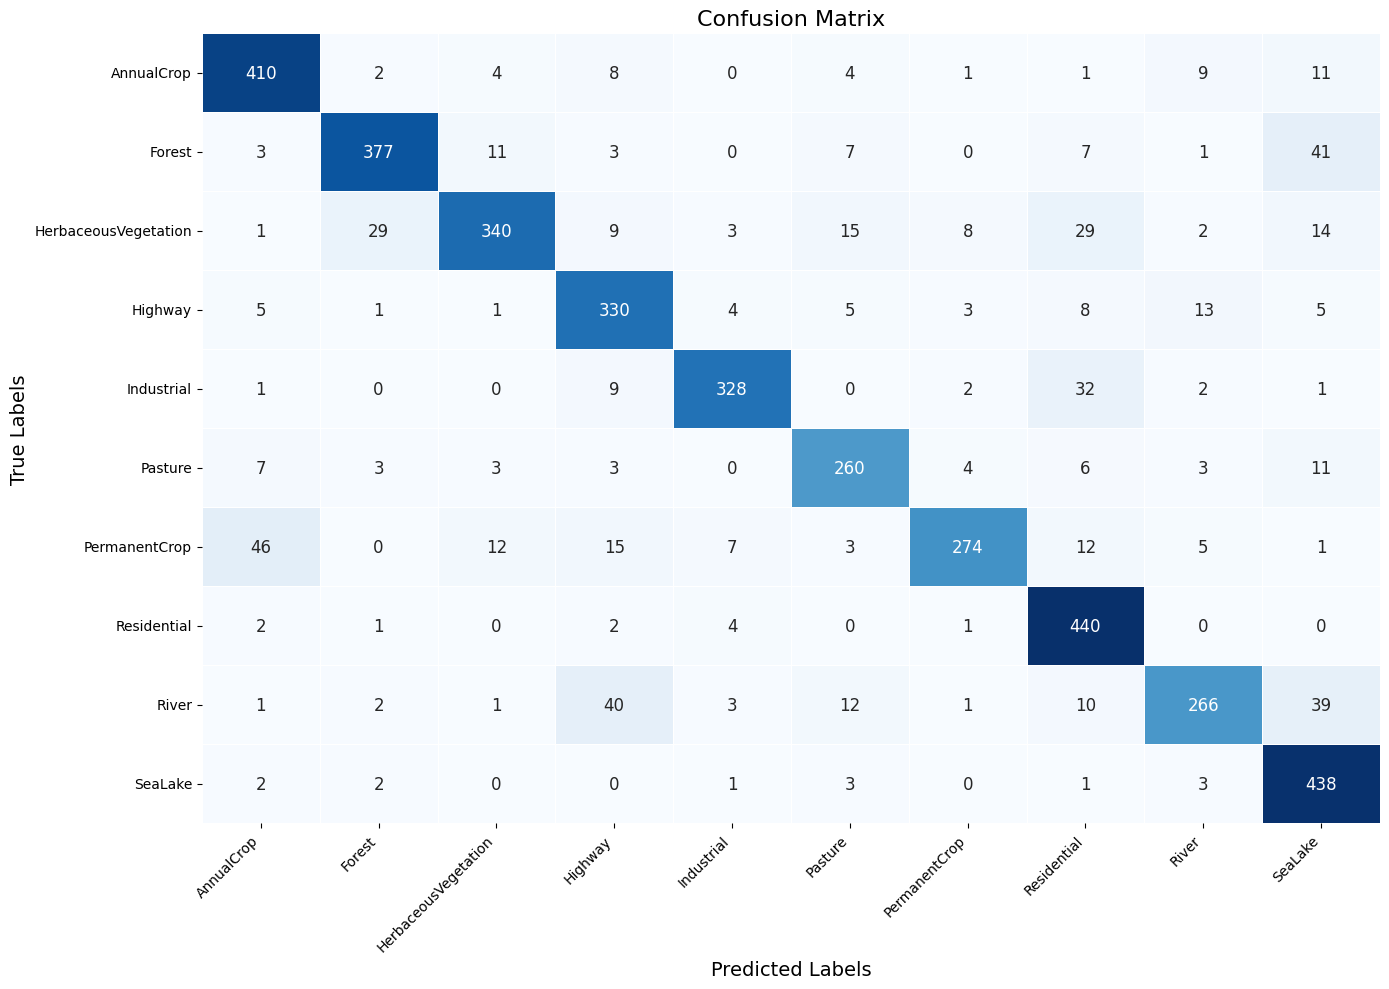

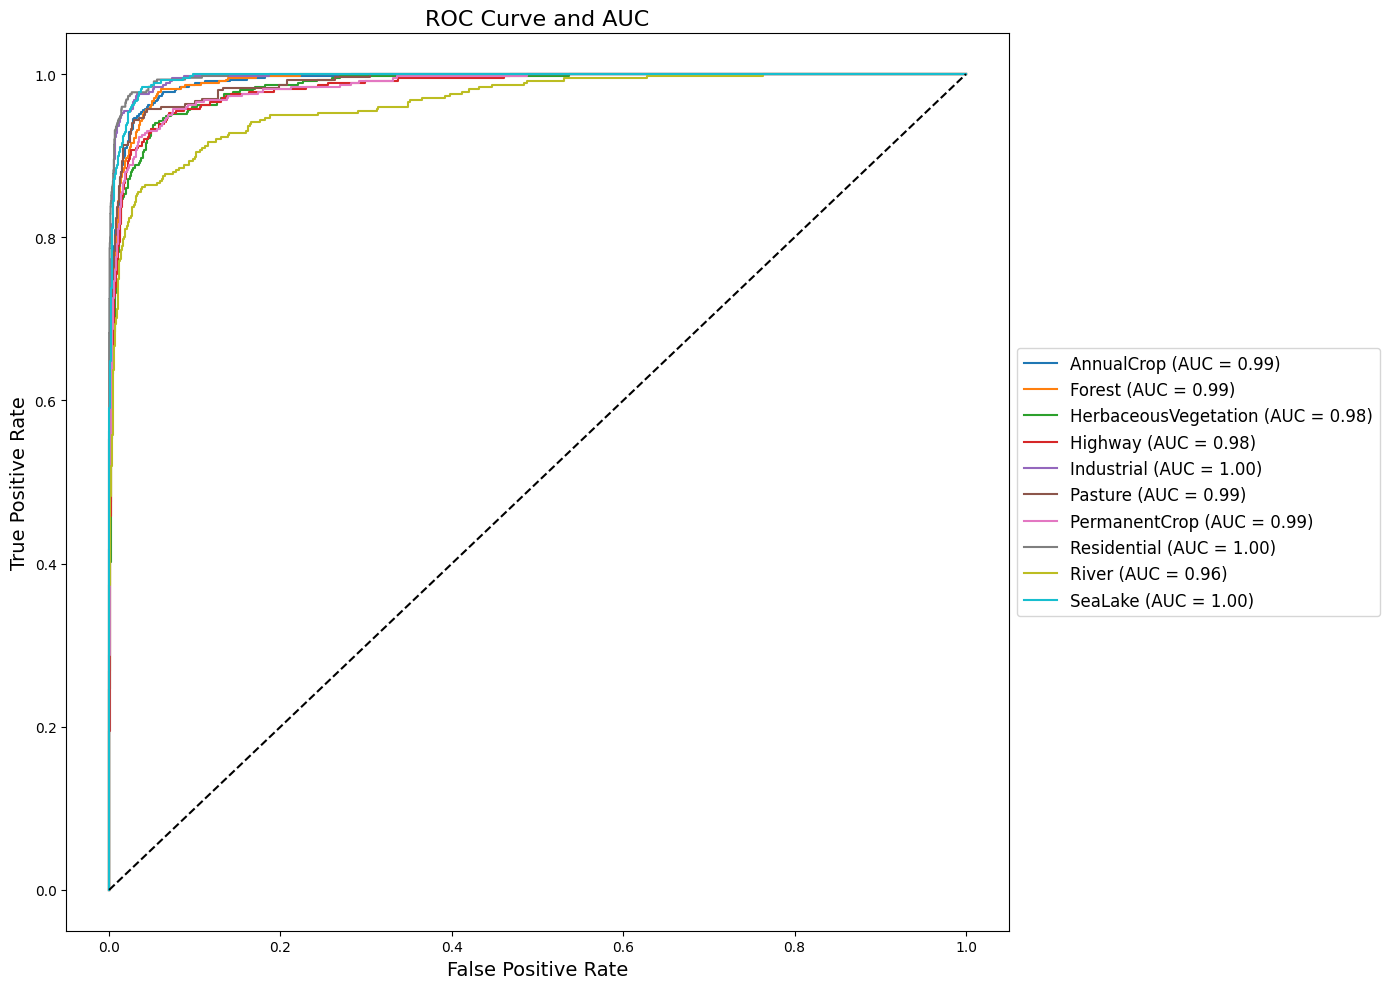

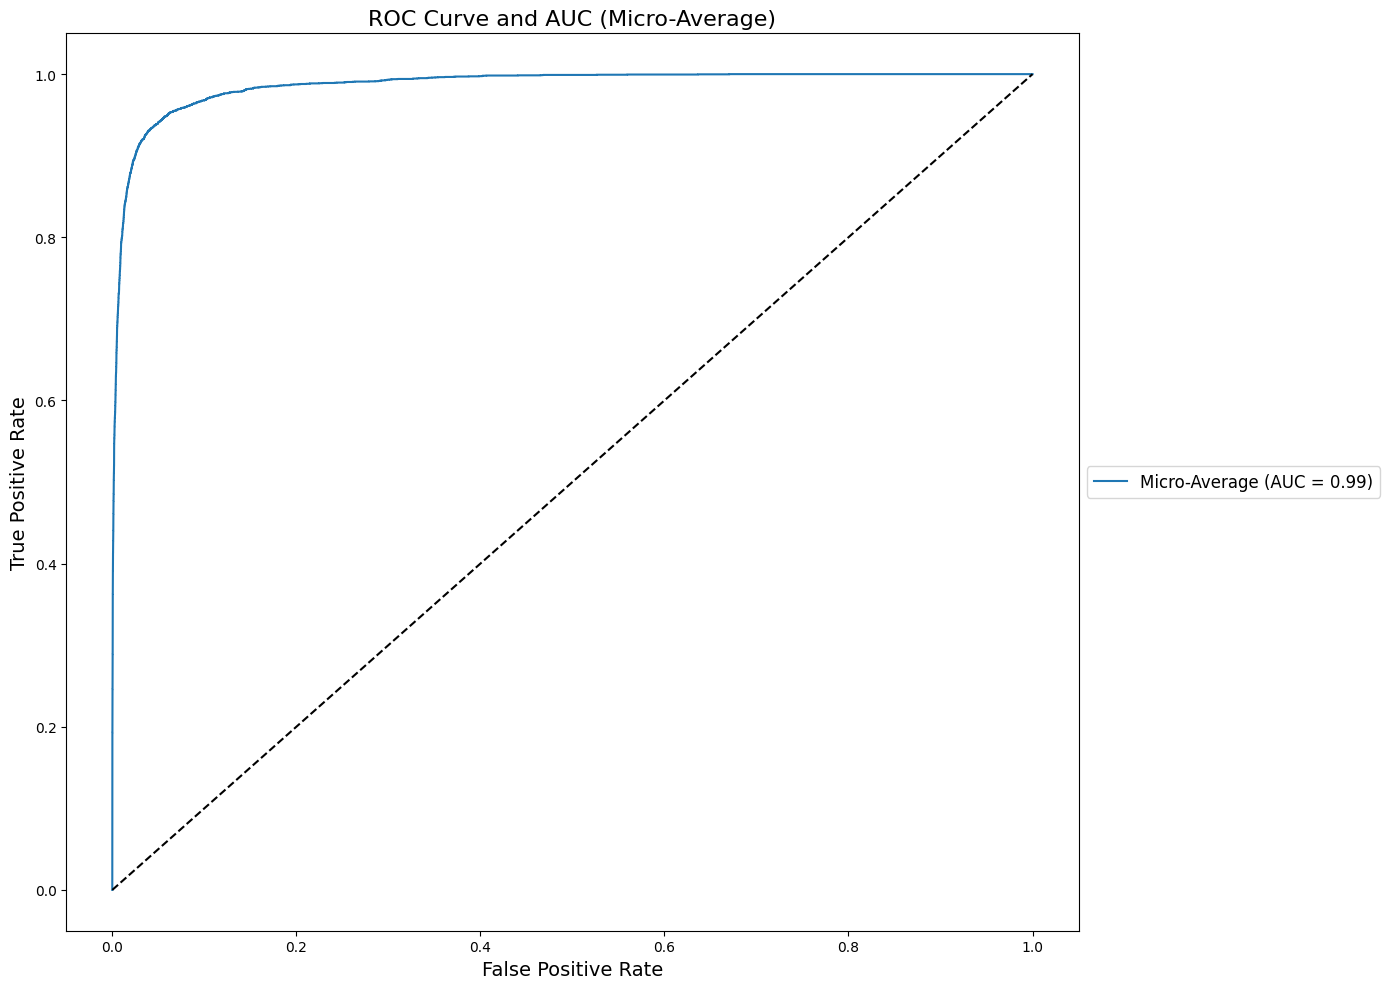

In [22]:
evaluate_and_plot_roc_auc(model, val_loader, train_dataset.classes, train_dataset)

In [23]:
torch.save(model.state_dict(), 'model.pth')